# 1. 라이브러리 불러오기

In [14]:
import pandas as pd
import numpy as np

pd.set_option('max.columns', 1000)

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

plt.rcParams['font.family'] = 'AppleGothic'
matplotlib.rcParams['axes.unicode_minus'] = False
plt.style.use('ggplot')
%matplotlib inline

import warnings
warnings.filterwarnings(action = 'ignore')

from scipy import stats
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_val_predict, cross_val_score, KFold, GridSearchCV, train_test_split
from sklearn.metrics import make_scorer

# 2. 데이터 불러오기

In [15]:
# 데이터 확인
raw_data = pd.read_csv('data/train_mdf.csv')

print('Shape of Data :', raw_data.shape, '\n')
print('-' * 50)
print(raw_data.info())

Shape of Data : (1460, 81) 

--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1

# 3. 결측치 처리

In [16]:
object_list = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
               'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 
               'PoolQC', 'Fence', 'MiscFeature']

# 원래 데이터를 보존하기 위해 새로운 DataFrame 생성
modify_data = raw_data.copy()

# 결측치를 의미하지 않는 값에 'No have' 채워넣기
for feature in object_list:
    null_data = modify_data[feature].isnull().sum()
    print('Number of null values of {} *Before Modify* :'.format(feature), null_data, '\n')
    
    modify_data.loc[modify_data[feature].isnull(), feature] = 'No have'
    
    null_data = modify_data[feature].isnull().sum()
    print('Number of null values of {} *After Modify* :'.format(feature), null_data)
    print('-' * 60)

Number of null values of Alley *Before Modify* : 1369 

Number of null values of Alley *After Modify* : 0
------------------------------------------------------------
Number of null values of BsmtQual *Before Modify* : 37 

Number of null values of BsmtQual *After Modify* : 0
------------------------------------------------------------
Number of null values of BsmtCond *Before Modify* : 37 

Number of null values of BsmtCond *After Modify* : 0
------------------------------------------------------------
Number of null values of BsmtExposure *Before Modify* : 38 

Number of null values of BsmtExposure *After Modify* : 0
------------------------------------------------------------
Number of null values of BsmtFinType1 *Before Modify* : 37 

Number of null values of BsmtFinType1 *After Modify* : 0
------------------------------------------------------------
Number of null values of BsmtFinType2 *Before Modify* : 38 

Number of null values of BsmtFinType2 *After Modify* : 0
---------------

In [17]:
# Garage를 가지고 있지 않은 관측치는 년도가 기입되어 있지 않으므로 '9999' 대입
print('Number of null values of GarageYrBlt *Before Modify* :', modify_data['GarageYrBlt'].isnull().sum(), '\n')

# 결측치 대체
modify_data.loc[modify_data['GarageYrBlt'].isnull(), 'GarageYrBlt'] = 9999
print('Number of null values of GarageYrBlt *After Modify* :', modify_data['GarageYrBlt'].isnull().sum())

Number of null values of GarageYrBlt *Before Modify* : 81 

Number of null values of GarageYrBlt *After Modify* : 0


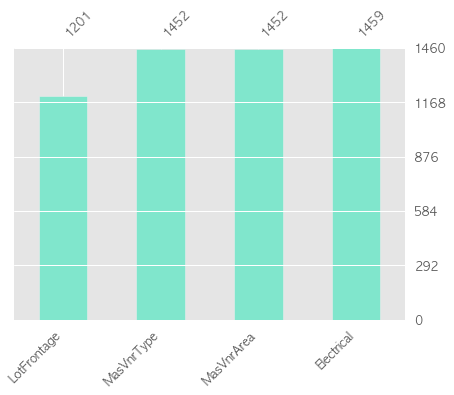

In [18]:
# 변경해준 뒤 결측치 확인
null_data = pd.DataFrame(modify_data.isnull().sum(), columns = ['Count'])
null_list = null_data[null_data['Count'] > 0].index

# 추출 후 시각화
msno.bar(modify_data[null_list], color = (0.5, 0.9, 0.8), fontsize = 12, figsize = (7, 5))
plt.yticks([])
plt.show()

- **MasVnrType**의 값이 결측치일 때, **MasVnrArea**의 값 역시 결측치임을 확인할 수 있다.


- 결측치의 개수가 8개 뿐이므로 **MasVnrType** 변수에는 **'None'** 의 값을, **MasVnrArea** 변수에는 **'0'** 의 값을 넣어주자.


- **Electrical** 변수의 경우 1개의 결측치가 있으며, 최빈값으로 대체해주도록 하자.

In [19]:
print('Number of null values of MasVnrType *Before* :', modify_data['MasVnrType'].isnull().sum(), '\n')
print('Number of null values of MasVnrArea *Before* :', modify_data['MasVnrArea'].isnull().sum(), '\n')
print('Number of null values of Electrical *Before* :', modify_data['Electrical'].isnull().sum(), '\n')

modify_data['MasVnrType'].fillna('None', inplace = True)
modify_data['MasVnrArea'].fillna(0, inplace = True)
modify_data['Electrical'].fillna(modify_data['Electrical'].mode()[0], inplace = True)

print('Number of null values of MasVnrType *After* :', modify_data['MasVnrType'].isnull().sum(), '\n')
print('Number of null values of MasVnrArea *After* :', modify_data['MasVnrArea'].isnull().sum(), '\n')
print('Number of null values of Electrical *After* :', modify_data['Electrical'].isnull().sum())

Number of null values of MasVnrType *Before* : 8 

Number of null values of MasVnrArea *Before* : 8 

Number of null values of Electrical *Before* : 1 

Number of null values of MasVnrType *After* : 0 

Number of null values of MasVnrArea *After* : 0 

Number of null values of Electrical *After* : 0


In [20]:
# 'LotFrontage' 결측치를 대체해주는 함수 만들기
def imputer_lotfrontage(raw_data):
    
    print('Number of null values of LotFrontage *Before Modify* :', raw_data['LotFrontage'].isnull().sum(), '\n')
    
    # 'KNNImputer' 라이브러리 불러오기
    from sklearn.impute import KNNImputer
    
    # 'LotFrontage' 변수에 결측치를 가지는 'Id' 추출 후 저장
    miss_id = raw_data[raw_data['LotFrontage'].isnull()]['Id'].unique()
    
    # 'Id', 'LotFrontage', 'LotArea' 변수 추출 후 저장
    data = raw_data[['Id', 'LotFrontage', 'LotArea']]
    
    # 'LotFrontage' 변수의 값이 300 넘는 관측치를 삭제하기로 했으므로 삭제
    outlier_id = data[data['LotFrontage'] > 300]['Id']
    data = data[~data['Id'].isin(outlier_id)]
    
    # 'Id' 변수를 인덱스로 지정
    data = data.set_index('Id')
    
    # 'LotArea' 변수를 로그화 수행 후, 변수 삭제
    data['LotLogArea'] = data['LotArea'].apply(lambda x: np.log(x))
    data = data.drop('LotArea', axis = 1)
    
    # 모델 객체 생성 후 학습시키고 DataFrame으로 저장
    # 원본 데이터에 결측치로 기입되어 있는 관측치들만 수정해주기 위해 DataFrame을 만들 때, 인덱스를 위 데이터의 인덱스로 지정
    imputer = KNNImputer(n_neighbors = 5)
    pre_data = pd.DataFrame(imputer.fit_transform(data), columns = data.columns, index = data.index)
    
    # 결측치가 존재하던 관측치만 저장
    pre_data = pre_data[pre_data.index.isin(miss_id)]
    
    # 원본 데이터 결측치를 대입해주는 과정
    for id_value, lot_value in zip(pre_data.index, pre_data['LotFrontage']):
        for index in raw_data.index:
            
            if raw_data.loc[index, 'Id'] == id_value:
                raw_data.loc[index, 'LotFrontage'] = lot_value
    
    print('Number of null values of LotFrontage *After Modify* :', raw_data['LotFrontage'].isnull().sum())
 
    return raw_data

In [21]:
# 생성한 함수 적용
modify_data = imputer_lotfrontage(modify_data)

Number of null values of LotFrontage *Before Modify* : 259 

Number of null values of LotFrontage *After Modify* : 0


# 4. 변수 타입 변경 및 생성

In [22]:
# 'float' 타입의 변수들을 'int64' 타입으로 바꿔주기
modify_data['LotFrontage'] = modify_data['LotFrontage'].astype('int64')
modify_data['MasVnrArea'] = modify_data['MasVnrArea'].astype('int64')
modify_data['GarageYrBlt'] = modify_data['GarageYrBlt'].astype('int64')

# 'MSSubClass' 변수의 경우 범주형 변수를 뜻하지만 정수형 타입으로 되어있으므로 변경
modify_data['MSSubClass'] = modify_data['MSSubClass'].astype('int64')

# 순서형 변수 중 문자열 타입으로 되어있는 변수를 변환
# 'ExterQual' & 'ExterCond'
mapping = {'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po' : 1}

modify_data['ExterQual'] = modify_data['ExterQual'].map(mapping)
modify_data['ExterCond'] = modify_data['ExterCond'].map(mapping)

# 'BsmtQual' & 'BsmtCond'
mapping = {'No have' : 0, 'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5}

modify_data['BsmtQual'] = modify_data['BsmtQual'].map(mapping)
modify_data['BsmtCond'] = modify_data['BsmtCond'].map(mapping)

# 'HeatingQC'
mapping = {'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5}

modify_data['HeatingQC'] = modify_data['HeatingQC'].map(mapping)

# 'KitchenQual'
mapping = {'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5}

modify_data['KitchenQual'] = modify_data['KitchenQual'].map(mapping)

# 'FireplaceQu'
mapping = mapping = {'No have' : 0, 'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5}

modify_data['FireplaceQu'] = modify_data['FireplaceQu'].map(mapping)

# 'GarageQual' & 'GarageCond'
mapping = mapping = {'No have' : 0, 'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5}

modify_data['GarageQual'] = modify_data['GarageQual'].map(mapping)
modify_data['GarageCond'] = modify_data['GarageCond'].map(mapping)

# 'PoolQC'
mapping = mapping = {'No have' : 0, 'Fa' : 1, 'TA' : 2, 'Gd' : 3, 'Ex' : 4}

modify_data['PoolQC'] = modify_data['PoolQC'].map(mapping)

In [23]:
# 'SalePrice' 로그 수행
print('Shape of modify_data *Before Create* :', modify_data.shape, '\n')

modify_data['LogSalePrice'] = np.log1p(modify_data['SalePrice'])
print('Shpae of modify_data *After Create* :', modify_data.shape)

Shape of modify_data *Before Create* : (1460, 81) 

Shpae of modify_data *After Create* : (1460, 82)


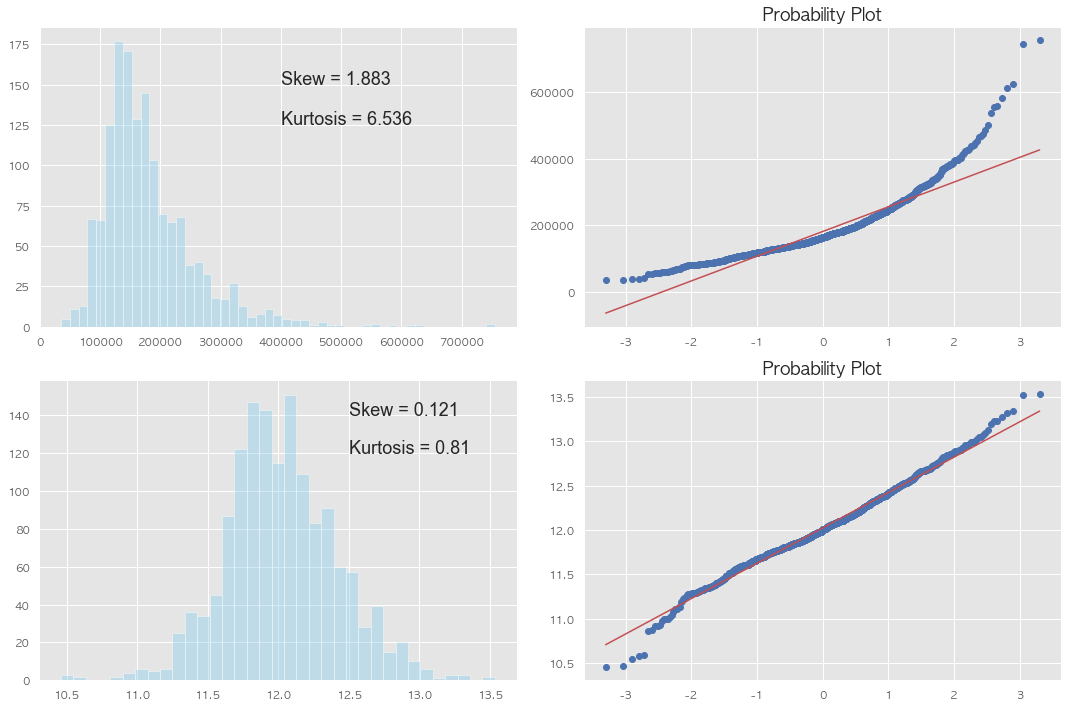

In [24]:
# 'SalePrice'와 'LogSalePrice' 변수 시각화
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (15, 10))
sns.set(font_scale = 1.5)

# 'SalePrice' 변수의 왜도와 첨도 저장
price_skew = 'Skew = {}'.format(round(modify_data['SalePrice'].skew(), 3))
price_kurtosis = 'Kurtosis = {}'.format(round(modify_data['SalePrice'].kurtosis(), 3)) 

# 'LogSalePrice' 변수의 왜도와 첨도 저장
log_skew = 'Skew = {}'.format(round(modify_data['LogSalePrice'].skew(), 3))
log_kurtosis = 'Kurtosis = {}'.format(round(modify_data['LogSalePrice'].kurtosis(), 3))

# SalePrice
sns.distplot(modify_data['SalePrice'], color = 'skyblue', kde = False, ax = axes[0][0])
axes[0][0].text(400000, 150, price_skew)
axes[0][0].text(400000, 125, price_kurtosis)
axes[0][0].set_xlabel('')

stats.probplot(modify_data['SalePrice'], plot = axes[0][1])
axes[0][1].set_xlabel('')
axes[0][1].set_ylabel('')

# 'LogSalePrice'
sns.distplot(modify_data['LogSalePrice'], color = 'skyblue', kde = False, ax = axes[1][0])
axes[1][0].text(12.5, 140, log_skew)
axes[1][0].text(12.5, 120, log_kurtosis)
axes[1][0].set_xlabel('')

stats.probplot(modify_data['LogSalePrice'], plot = axes[1][1])
axes[1][1].set_xlabel('')
axes[1][1].set_ylabel('')

sns.set(font_scale = 1)
fig.tight_layout()

- 로그화를 수행해준 뒤, 완벽히 정규분포를 따른다고 할 수 없지만 기존 변수보다 정규분포를 따르고 있다.


- 분석에 사용 될 변수를 생성해주도록 하자.

In [25]:
print('Shape of modify_data *Before Create* :', modify_data.shape, '\n')

# 'NewLotShape' 변수 생성
modify_data['NewLotShape'] = modify_data['LotShape'].apply(lambda x: 'Reg' if x == 'Reg' else 'IR')

# 'Condition1' 변수를 Norm, Street, Positive, Rail 4개의 범주로 통합한 'NewCondition1' 변수 생성
modify_data['NewCondition1'] = np.nan

for index in modify_data.index:
    
    value = modify_data.loc[index, 'Condition1']
    
    if (value == 'Artery') | (value == 'Feedr'):
        modify_data.loc[index, 'NewCondition1'] = 'Street'
        
    elif (value == 'PosN') | (value == 'PosA'):
        modify_data.loc[index, 'NewCondition1'] = 'Positive'
        
    elif value == 'Norm':
        modify_data.loc[index, 'NewCondition1'] = 'Norm'
        
    else:
        modify_data.loc[index, 'NewCondition1'] = 'Rail'

# 'Condition1'과 'Condition2' 변수를 함께 사용하여 조건이 없는 경우와 조건이 한 개 이상인 경우를 나타내는 변수 생성
modify_data['CountCon'] = np.nan

for index in modify_data.index:
    
    first_value = modify_data.loc[index, 'Condition1']
    second_value = modify_data.loc[index, 'Condition2']
    
    # 'Condition1'과 'Condition2' 변수 모두 'Norm'인 경우
    if (first_value == 'Norm') & (second_value == 'Norm'):
        modify_data.loc[index, 'CountCon'] = 0
    
    else:
        modify_data.loc[index, 'CountCon'] = 1

modify_data['CountCon'] = modify_data['CountCon'].astype('int64')
        
# 'BsmtExposure' 변수를 사용하여 Exposure이 존재하면 1, 그렇지 않으면 0을 의미하는 NewBsmtExposure 변수 생성
modify_data['NewBsmtExposure'] = np.nan

for index in modify_data.index:
    
    value = modify_data.loc[index, 'BsmtExposure']
    
    if (value == 'No') | (value == 'No have'):
        modify_data.loc[index, 'NewBsmtExposure'] = 0
    
    else:
        modify_data.loc[index, 'NewBsmtExposure'] = 1
        
modify_data['NewBsmtExposure'] = modify_data['NewBsmtExposure'].astype('int64')
        
# 'Electrical' 변수를 SBrkr과 Other 두 범주로 바꿔주도록 하자.
modify_data['Electrical'] = modify_data['Electrical'].apply(lambda x: x if x == 'SBrkr' else 'Other')

# 'SaleCondition' 변수를 Normal, Partial, Abnorml, Other 4개의 범주로 축소한 변수 생성
modify_data['NewSaleCondition'] = np.nan

for index in modify_data.index:
    
    value = modify_data.loc[index, 'SaleCondition']
    
    if value == 'Normal':
        modify_data.loc[index, 'NewSaleCondition'] = value
        
    elif value == 'Partial':
        modify_data.loc[index, 'NewSaleCondition'] = value
        
    elif value == 'Abnorml':
        modify_data.loc[index, 'NewSaleCondition'] = value
        
    else:
        modify_data.loc[index, 'NewSaleCondition'] = 'Other'
        
print('Shape of modify_data *After Create* :', modify_data.shape)

Shape of modify_data *Before Create* : (1460, 82) 

Shape of modify_data *After Create* : (1460, 87)


In [26]:
print('Shape of modify_data *Before Create* :', modify_data.shape, '\n')

# 'HeatingQC'변수를 사용하여 Excellent 범주에 해당하면 1, 그렇지 않으면 0을 의미하는 새로운 변수 생성
modify_data['NewHeatingQC'] = modify_data['HeatingQC'].apply(lambda x: 1 if x == 5 else 0)
modify_data['NewHeatingQC'] = modify_data['NewHeatingQC'].astype('int64')

# 건축일로부터 몇년후에 리모델링을 했는지 나타내는 변수 생성
modify_data['DiffYear'] = modify_data['YearRemodAdd'] - modify_data['YearBuilt']

# 리모델링 여부를 나타내는 변수 생성
modify_data['Remodel'] = modify_data['DiffYear'].apply(lambda x: 1 if x > 0 else 0)
modify_data['Remodel'] = modify_data['Remodel'].astype('int64')

# 1950년도 이후에 지어진 건물은 1, 1950년대 이전에 지어진 건물은 0을 나타내는 변수 생성
modify_data['Year_1950'] = modify_data['YearBuilt'].apply(lambda x: 1 if x >= 1950 else 0)
modify_data['Year_1950'] = modify_data['Year_1950'].astype('int64')

# 1950년도 이전에 건축된 건물이면 1
# 1950년도 이후에 건축되고 리모델링을 수행하지 않았으면 2
# 1950년도 이후에 건축되고 리모델링을 수행했으면 3
modify_data['NewBuiltRemod'] = np.nan

for index in modify_data.index:
    
    year = modify_data.loc[index, 'YearBuilt']
    remodel = modify_data.loc[index, 'Remodel']
    
    if year < 1950:
        modify_data.loc[index, 'NewBuiltRemod'] = 1
    
    elif (year >= 1950) & (remodel == 0):
        modify_data.loc[index, 'NewBuiltRemod'] = 2
    
    else:
        modify_data.loc[index, 'NewBuiltRemod'] = 3

modify_data['NewBuiltRemod'] = modify_data['NewBuiltRemod'].astype('int64')

# 'GarageYrBlt', 'YearBuilt', 'YearRemodAdd' 세 변수를 사용해서 새로운 변수 생성
# 차고가 없는 경우는 0
# 건물이 건축될 때 차고가 같이 생긴 경우는 1
# 리모델링을 하면서 차고가 생긴 경우는 2
# 그 외의 경우는 3
modify_data['GarageBuiltRemod'] = np.nan

for index in modify_data.index:
    
    
    built = modify_data.loc[index, 'YearBuilt']
    remod = modify_data.loc[index, 'YearRemodAdd']
    garage = modify_data.loc[index, 'GarageYrBlt']
    
    # 차고가 없는 경우
    if garage == 9999:
        modify_data.loc[index, 'GarageBuiltRemod'] = 0
    
    # 건축날짜와 리모델링 날짜가 같은 경우
    elif built == remod:
        
        if built == garage:
            modify_data.loc[index, 'GarageBuiltRemod'] = 1
        
        else:
            modify_data.loc[index, 'GarageBuiltRemod'] = 3
    
    # 건축날짜와 리모델링 날짜가 다른 경우
    elif built != remod:
        
        # 차고가 생성된 날짜와 건축 날짜가 같다면 건물이 건축될 때 같이 생겼음을 의미한다.
        if built == garage:
            modify_data.loc[index, 'GarageBuiltRemod'] = 1
        
        # 리모델링을 수행한 날짜와 같다면 리모델링을 수행할 당시 생겼다고 가정하자.
        elif remod == garage:
            modify_data.loc[index, 'GarageBuiltRemod'] = 2
        
        else:
            modify_data.loc[index, 'GarageBuiltRemod'] = 3

modify_data['GarageBuiltRemod'] = modify_data['GarageBuiltRemod'].astype('int64')


print('Shape of modify_data *After Create* :', modify_data.shape)

Shape of modify_data *Before Create* : (1460, 87) 

Shape of modify_data *After Create* : (1460, 93)


In [27]:
# 연속형 독립변수의 이상치 대체

# 'TotalBsmtSF'의 값이 3000이 넘는 관측치들을 중앙값으로 대체해주자.
median_value = modify_data[modify_data['TotalBsmtSF'] < 3000]['TotalBsmtSF'].median()

modify_data.loc[modify_data['TotalBsmtSF'] > 3000, 'TotalBsmtSF'] = median_value

# '1stFlrSF'의 값이 3000이 넘는 관측치들을 중앙값으로 대체해주자.
median_value = modify_data[modify_data['1stFlrSF'] < 3000]['1stFlrSF'].median()

modify_data.loc[modify_data['1stFlrSF'] > 3000, '1stFlrSF'] = median_value

# 'GrLivArea'의 값이 4000이 넘는 관측치들을 중앙값으로 대체해주자.
median_value = modify_data[modify_data['GrLivArea'] < 4000]['GrLivArea'].median()

modify_data.loc[modify_data['GrLivArea'] > 4000, 'GrLivArea'] = median_value

In [28]:
print('Shape of modify_data *Before Create* :', modify_data.shape, '\n')

# 'BsmtFullBath'와 'BsmtHalfBath' 변수를 이용하여 'BsmtTotalBath' 변수 생성 
modify_data['BsmtTotalBath'] = modify_data['BsmtFullBath'] + modify_data['BsmtHalfBath']


# 'FullBath'와 'HalfBath' 변수를 이용하여 'GradeTotalBath' 변수 생성
modify_data['GradeTotalBath'] = modify_data['FullBath'] + modify_data['HalfBath']

# 'LotFrontage' 변수 로그화
modify_data['LogLotFrontage'] = np.log1p(modify_data['LotFrontage'])

# 'LotArea' 변수 로그화
modify_data['LogLotArea'] = np.log1p(modify_data['LotArea'])

# 2층의 여부를 나타내는 변수 만들기
modify_data['Exist2nd'] = modify_data['2ndFlrSF'].apply(lambda x: 0 if x == 0 else 1)
modify_data['Exist2nd'] = modify_data['Exist2nd'].astype('int64')

# 'WoodDeckSF' 변수를 이용하여 WoodDeck 보유 여부를 나타내는 변수 생성
modify_data['ExistWoodDeck'] = modify_data['WoodDeckSF'].apply(lambda x: 0 if x == 0 else 1)
modify_data['ExistWoodDeck'] = modify_data['ExistWoodDeck'].astype('int64')

# 'ExistPorch' 변수 생성
modify_data['TotalPorch'] = modify_data['OpenPorchSF'] + modify_data['EnclosedPorch'] + \
                            modify_data['3SsnPorch'] + modify_data['ScreenPorch']

# 'TotalPorch' 변수를 사용하여 보유 여부 변수 생성
modify_data['ExistPorch'] = modify_data['TotalPorch'].apply(lambda x: 0 if x == 0 else 1)
modify_data['ExistPorch'] = modify_data['ExistPorch'].astype('int64')

print('Shape of modify_data *After Create* :', modify_data.shape)

Shape of modify_data *Before Create* : (1460, 93) 

Shape of modify_data *After Create* : (1460, 101)


# 5. Norminal Variables Selection

**명목형 변수 중 사용하고자 하는 변수**

- MSSubClass


- MSZoning


- Alley


- NewLotShape


- LandContour


- Neighborhood


- NewCondition1


- BldgType


- CountCon


- HouseStyle


- RoofStyle


- MasVnrType


- Foundation


- NewBsmtExposure


- BsmtFinType1


- CentralAir


- Electrical


- GarageType


- GarageFinish


- PavedDrive


- SaleType


- NewSaleCondition

In [29]:
# 변수가 많으므로 회귀모델을 돌려 유의한 변수만 추출
value_list = ['MSSubClass', 'MSZoning', 'Alley', 'NewLotShape', 'LandContour', 'Neighborhood',
              'NewCondition1', 'BldgType', 'CountCon', 'HouseStyle', 'RoofStyle', 'MasVnrType',
              'Foundation', 'NewBsmtExposure', 'BsmtFinType1', 'CentralAir', 'Electrical', 
              'GarageType', 'GarageFinish', 'PavedDrive', 'SaleType', 'NewSaleCondition']

X = modify_data[value_list]

# 범주형 변수이므로 가변수 처리
X = pd.get_dummies(X, drop_first = True)

# 상수항 추가
X = sm.add_constant(X)

# 종속변수 지정
y = modify_data['LogSalePrice']

In [30]:
# 모델 생성 후 학습시키기
nor_model = sm.OLS(y, X).fit()

# 'P-value'를 저장한 DataFrame 생성
nor_model_data = pd.DataFrame(nor_model.pvalues, columns = ['P-value'])

# 유의수준이 0.05보다 낮은 변수만 저장
nor_model_data = nor_model_data[nor_model_data['P-value'] < 0.05]

# 데이터 확인
nor_model_data.sort_index()

,P-value
BldgType_Duplex,1.396778e-02
BldgType_Twnhs,7.594745e-04
BldgType_TwnhsE,5.281941e-04
BsmtFinType1_GLQ,4.539355e-03
BsmtFinType1_No have,1.485590e-03
BsmtFinType1_Unf,1.526713e-03
CentralAir_Y,1.784886e-13
Electrical_SBrkr,2.957056e-02
Foundation_PConc,6.052737e-03
Foundation_Stone,2.750469e-02


- 유의수준 0.05에서 유의한 변수는 **BldgType, BsmtFinType1, CentralAir, Electrical, Foundation, GarageFinish, GarageType, HouseStyle, MSZoning, MasVnrType, Neighborhood, NewBsmtExposure, NewCondition1, NewLotShape, NewSaleCondition, PavedDrive, RoofStyle, SaleType** 임을 확인할 수 있다.

# 6. Ordinal Variables Selection

**순서형 변수 중 사용하고자 하는 변수**

- OverallQual


- ExterQual


- BsmtQual


- BsmtCond


- NewHeatingQC


- KitchenQual


- FireplaceQu


- NewBuiltRemod


- GarageBuiltRemod

In [31]:
# 변수가 많으므로 회귀모델을 돌려 유의한 변수만 추출
value_list = ['OverallQual', 'ExterQual', 'BsmtQual', 'BsmtCond', 'NewHeatingQC', 'KitchenQual', 
              'FireplaceQu', 'NewBuiltRemod', 'GarageBuiltRemod']

X = modify_data[value_list]
X = X.astype('str')

# 순서를 나타내지만 범주형 변수이므로 가변수 처리
X = pd.get_dummies(X, drop_first = True)

# 상수항 추가
X = sm.add_constant(X)

# 종속변수 지정
y = modify_data['LogSalePrice']

In [32]:
# 모델 생성 후 학습시키기
or_model = sm.OLS(y, X).fit()

# 'P-value'를 저장한 DataFrame 생성
or_model_data = pd.DataFrame(or_model.pvalues, columns = ['P-value'])

# 유의수준이 0.05보다 낮은 변수만 저장
or_model_data = or_model_data[or_model_data['P-value'] < 0.05]

# 데이터 확인
or_model_data.sort_index()

,P-value
FireplaceQu_2,1.300058e-03
FireplaceQu_3,4.488010e-28
FireplaceQu_4,8.012096e-20
FireplaceQu_5,5.082575e-05
GarageBuiltRemod_1,1.208207e-08
GarageBuiltRemod_2,2.233854e-07
GarageBuiltRemod_3,1.700893e-07
KitchenQual_4,1.440901e-02
KitchenQual_5,4.429247e-04
NewBuiltRemod_2,3.189815e-08


# 7. Discrete & Continuous Variables Selection

**이산형, 연속형 변수 중 사용하고자 하는 변수**

- BsmtTotalBath


- GradeTotalBath


- BedroomAbvGr


- KitchenAbvGr


- Fireplaces


- LogLotFrontage


- LogLotArea


- MasVnrArea


- BsmtFinSF1


- TotalBsmtSF


- 1stFlrSF


- Exist2nd


- GrLivArea


- GarageArea


- ExistWoodDeck


- ExistPorch

In [33]:
# 변수가 많으므로 회귀모델을 돌려 유의한 변수만 추출
value_list = ['BsmtTotalBath', 'GradeTotalBath', 'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces',
              'LogLotFrontage', 'LogLotArea', 'MasVnrArea', 'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF',
              'Exist2nd', 'GrLivArea', 'GarageArea', 'ExistWoodDeck', 'ExistPorch']

X = modify_data[value_list]

# 상수항 추가
X = sm.add_constant(X)

# 종속변수 지정
y = modify_data['LogSalePrice']

In [34]:
# 모델 생성 후 학습시키기
nu_model = sm.OLS(y, X).fit()

# 'P-value'를 저장한 DataFrame 생성
nu_model_data = pd.DataFrame(nu_model.pvalues, columns = ['P-value'])

# 유의수준이 0.05보다 낮은 변수만 저장
nu_model_data = nu_model_data[nu_model_data['P-value'] < 0.05]

# 데이터 확인
nu_model_data.sort_index()

,P-value
BedroomAbvGr,1.072339e-06
BsmtFinSF1,9.483817e-03
BsmtTotalBath,5.355493e-05
ExistPorch,1.832283e-03
ExistWoodDeck,6.874801e-07
Fireplaces,2.813013e-05
GarageArea,4.480260e-33
GrLivArea,5.957841e-22
GradeTotalBath,1.956017e-42
KitchenAbvGr,2.897138e-24


In [35]:
# 최종적으로 사용할 변수만 저장
final_list = ['BldgType', 'BsmtFinType1', 'CentralAir', 'Electrical', 'Foundation', 'GarageFinish', 
              'GarageType', 'HouseStyle', 'MSZoning', 'MasVnrType', 'Neighborhood', 'NewBsmtExposure',
              'NewCondition1', 'NewLotShape', 'NewSaleCondition', 'PavedDrive', 'RoofStyle', 'SaleType',
              'FireplaceQu', 'GarageBuiltRemod', 'KitchenQual', 'NewBuiltRemod', 'NewHeatingQC',
              'OverallQual', 'BedroomAbvGr', 'BsmtFinSF1', 'BsmtTotalBath', 'ExistPorch', 'ExistWoodDeck',
              'Fireplaces', 'GarageArea', 'GrLivArea', 'GradeTotalBath', 'KitchenAbvGr', 'LogLotArea', 
              'MasVnrArea', 'TotalBsmtSF', 'LogSalePrice']

# 최종 데이터 저장
final_data = modify_data[final_list]

# 문자열 타입으로 저장
for value in ['FireplaceQu', 'GarageBuiltRemod', 'KitchenQual', 'NewBuiltRemod', 'OverallQual']:
    final_data[value] = final_data[value].astype('str')

# 범주형 변수의 가변수 처리
final_dummies_data = pd.get_dummies(final_data, drop_first = True)

X = final_dummies_data.drop('LogSalePrice', axis = 1)
y = final_dummies_data['LogSalePrice']

final_dummies_data.head()

,NewBsmtExposure,NewHeatingQC,BedroomAbvGr,BsmtFinSF1,BsmtTotalBath,ExistPorch,ExistWoodDeck,Fireplaces,GarageArea,GrLivArea,GradeTotalBath,KitchenAbvGr,LogLotArea,MasVnrArea,TotalBsmtSF,LogSalePrice,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_No have,BsmtFinType1_Rec,BsmtFinType1_Unf,CentralAir_Y,Electrical_SBrkr,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,GarageFinish_No have,GarageFinish_RFn,GarageFinish_Unf,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_No have,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,NewCondition1_Positive,NewCondition1_Rail,NewCondition1_Street,NewLotShape_Reg,NewSaleCondition_Normal,NewSaleCondition_Other,NewSaleCondition_Partial,PavedDrive_P,PavedDrive_Y,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,FireplaceQu_1,FireplaceQu_2,FireplaceQu_3,FireplaceQu_4,FireplaceQu_5,GarageBuiltRemod_1,GarageBuiltRemod_2,GarageBuiltRemod_3,KitchenQual_3,KitchenQual_4,KitchenQual_5,NewBuiltRemod_2,NewBuiltRemod_3,OverallQual_10,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5,OverallQual_6,OverallQual_7,OverallQual_8,OverallQual_9
0,0,1,3,706,1,1,0,0,548,1710.0,3,1,9.042040,196,856,12.247699,0,0,0,0,0,1,0,0,0,0,1,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
1,1,1,3,978,1,0,1,1,460,1262.0,2,1,9.169623,0,1262,12.109016,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0
2,1,1,3,486,1,1,0,1,608,1786.0,3,1,9.328212,162,920,12.317171,0,0,0,0,0,1,0,0,0,0,1,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0
3,0,0,3,216,1,1,0,1,642,1717.0,1,1,9.164401,0,756,11.849405,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,1,1,4,655,1,1,1,1,836,2198.0,3,1,9.565284,350,1145,12.429220,0,0,0,0,0,1,0,0,0,0,1,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0


# 7. Modeling

## 7.1. Multiple Linear Regression

In [36]:
# 교차검증을 수행하여 model을 학습하고 RMSE와 시각화를 수행해주는 함수 생성
def modeling(model = None, X = None, y = None, n_split = None, random_state = None):
    
    # KFold 객체 생성
    kf = KFold(n_splits = n_split, shuffle = True, random_state = random_state)
    
    # RMSE 계산
    rmse = (np.sqrt(-cross_val_score(estimator = model, X = X, y = y, 
                                     scoring = 'neg_mean_squared_error', cv = kf))).mean()

    print('RMSE :', round(rmse, 5))

    # 시각화를 수행하기 위한 예측값 저장
    y_pred = cross_val_predict(estimator = model, X = X, y = y, cv = kf)
    
    # 시각화 과정
    plt.figure(figsize = (10, 5))
    
    sns.scatterplot(x = y, y = y_pred, alpha = 0.5)
    plt.text(10.7, 13, 'RMSE = {}'.format(round(rmse, 5)), fontdict = {'weight' : 'bold'}, fontsize = 14)
    plt.xlabel('Real value')
    plt.ylabel('Predict value')

RMSE : 0.13233


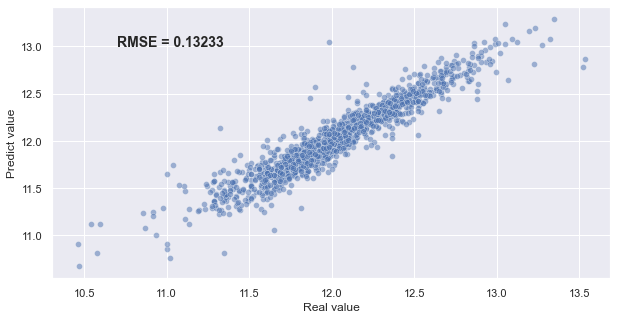

In [37]:
modeling(model = LinearRegression(), X = X, y = y, n_split = 10, random_state = 100)

## 7.2. Ridge Regression

In [38]:
# GridSearchCV를 통해 최적의 파라미터값 찾기
def grid_search(model = None, X = None, y = None, n_split = None, random_state = None, param = None):
    
    # GridSearchCV의 'scoring'을 RMSE로 변경해주기 위한 작업이 필요하다.
    def grid_rmse(actual, predict):
        
        # 수학 연산을 위해 numpy array로 변환한다.
        actual, predict = np.array(actual), np.array(predict)
        
        # RMSE 구하기
        rmse = np.sqrt(((actual - predict) ** 2).mean())
        
        # GridSearchCV의 'scoring' 인자는 값이 높을수록 좋은 모델이라고 평가하므로 '-'를 붙여주도록 한다.
        return -rmse
    
    score = make_scorer(grid_rmse)
    
    # KFold 객체 생성
    kf = KFold(n_splits = n_split, shuffle = True, random_state = random_state)
    
    # GridSearchCV 객체 생성
    grid = GridSearchCV(estimator = model, param_grid = param, scoring = score, cv = kf)
    
    # Grid Search 수행
    best_model = grid.fit(X, y)
    
    # Grid Search 수행 후, RMSE의 값을 출력할 때는 절대값을 취한다음 출력해주도록 한다.
    print('Best score of GridSearchCV :', np.absolute(best_model.best_score_), '\n')
    print('Best param of GridSearchCV :', best_model.best_params_)

In [39]:
# Ridge Regression의 alpha 값 지정
alpha_param = {'alpha' : [0.0001, 0.01, 0.05, 0.1, 0.5, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}

# GridSearchCV 수행
grid_search(model = Ridge(), X = X, y = y, n_split = 10, random_state = 100, param = alpha_param)

Best score of GridSearchCV : 0.13154694785163387 

Best param of GridSearchCV : {'alpha': 0.5}


- 생성한 함수를 통해 GridSearchCV를 수행해주었고, 처음은 alpha의 범위를 크게 하여 수행해주었다.


- 처음 GridSearchCV를 통해 Best alpha값은 **0.5**가 나왔으며, 0.1 ~ 1까지 0.1씩 증가하여 다시 수행해주도록 하자.

In [40]:
# Ridge Regression의 alpha 값 지정
alpha_param = {'alpha' : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}

# GridSearchCV 수행
grid_search(model = Ridge(), X = X, y = y, n_split = 10, random_state = 100, param = alpha_param)

Best score of GridSearchCV : 0.1315356503450136 

Best param of GridSearchCV : {'alpha': 0.6}


- 두 번의 반복을 통해 찾은 alpha의 값은 **0.6**임을 확인할 수 있다.

RMSE : 0.13154


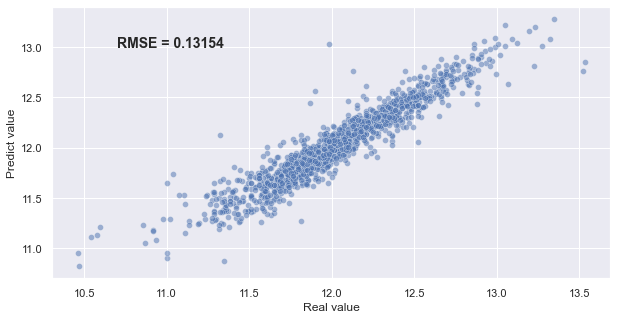

In [41]:
# alpha의 값을 0.6으로 지정하여 Ridge Regression을 수행해주도록 하자.
modeling(model = Ridge(alpha = 0.6), X = X, y = y, n_split = 10, random_state = 100)

## 7.3. Lasso Regression

In [42]:
# Lasso Regression의 alpha 값 지정
alpha_param = {'alpha' : [0.000001, 0.00001, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 1, 10, 20]}

# GridSearchCV 수행
grid_search(model = Lasso(), X = X, y = y, n_split = 10, random_state = 100, param = alpha_param)

Best score of GridSearchCV : 0.13090787903067655 

Best param of GridSearchCV : {'alpha': 0.0001}


In [43]:
# Lasso Regression의 alpha 값 지정
alpha_param = {'alpha' : [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001]}

# GridSearchCV 수행
grid_search(model = Lasso(), X = X, y = y, n_split = 10, random_state = 100, param = alpha_param)

Best score of GridSearchCV : 0.13090787903067655 

Best param of GridSearchCV : {'alpha': 0.0001}


RMSE : 0.13091


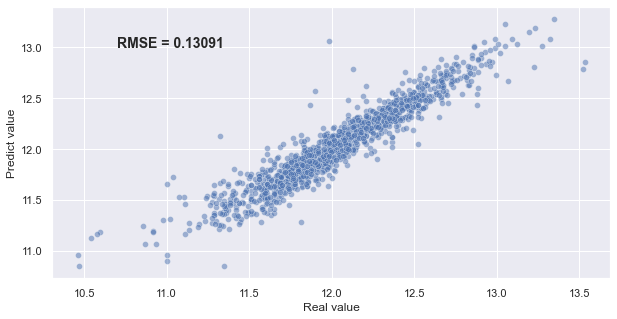

In [44]:
# alpha의 값을 0.0001으로 지정하여 Lasso Regression을 수행해주도록 하자.
modeling(model = Lasso(alpha = 0.0001), X = X, y = y, n_split = 10, random_state = 100)

## 7.4. Elastic Net Regression

In [45]:
# Elastic Net 파라미터 설정
elastic_param = {'alpha' : [0.00005, 0.0005, 0.005, 0.05, 0.5, 5, 10, 20, 30, 40, 50, 60, 70, 80],
                 'l1_ratio' : [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}

# GridSearchCV 수행
grid_search(model = ElasticNet(), X = X, y = y, n_split = 10, random_state = 100, param = elastic_param)

Best score of GridSearchCV : 0.13116869817610588 

Best param of GridSearchCV : {'alpha': 0.0005, 'l1_ratio': 0.2}


In [46]:
# Elastic Net 파라미터 설정
elastic_param = {'alpha' : [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001],
                 'l1_ratio' : [0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}

# GridSearchCV 수행
grid_search(model = ElasticNet(), X = X, y = y, n_split = 10, random_state = 100, param = elastic_param)

Best score of GridSearchCV : 0.13090787903067655 

Best param of GridSearchCV : {'alpha': 0.0001, 'l1_ratio': 1}


## 7.5. Stacking Ensemble

In [47]:
# PyCaret 라이브러리를 불러오기
from pycaret.regression import *

In [219]:
# PyCaret을 수행하기 위한 연속형 변수 지정
numerical_list = ['BedroomAbvGr', 'BsmtFinSF1', 'BsmtTotalBath', 'Fireplaces', 'GarageArea', 'GrLivArea', 
                  'GradeTotalBath', 'KitchenAbvGr']

# setup 지정
pycaret_setup = setup(data = final_data, numeric_features = numerical_list, target = 'LogSalePrice',
                      fold = 10, fold_shuffle = True, session_id = 100)

,Description,Value
0,session_id,100
1,Target,LogSalePrice
2,Original Data,"(1460, 38)"
3,Missing Values,False
4,Numeric Features,11
5,Categorical Features,26
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(1021, 139)"


In [228]:
best_model = compare_models(exclude = ['huber', 'lar'], cross_validation = True, 
                            sort = 'RMSE', n_select = 5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,0.0895,0.0171,0.1298,0.8904,0.0100,0.0075,0.0120
ridge,Ridge Regression,0.0901,0.0172,0.1304,0.8896,0.0101,0.0075,0.0050
lr,Linear Regression,0.0916,0.0178,0.1326,0.8859,0.0102,0.0077,0.2040
gbr,Gradient Boosting Regressor,0.0956,0.0187,0.1358,0.8801,0.0105,0.0080,0.0700
lightgbm,Light Gradient Boosting Machine,0.0991,0.0203,0.1418,0.8692,0.0110,0.0083,0.0290
rf,Random Forest Regressor,0.1015,0.0217,0.1469,0.8605,0.0114,0.0085,0.2670
et,Extra Trees Regressor,0.1050,0.0231,0.1517,0.8518,0.0118,0.0088,0.2800
omp,Orthogonal Matching Pursuit,0.1111,0.0243,0.1550,0.8442,0.0119,0.0093,0.0060
ada,AdaBoost Regressor,0.1324,0.0311,0.1761,0.7992,0.0136,0.0110,0.0540
en,Elastic Net,0.1484,0.0419,0.2041,0.7306,0.0157,0.0124,0.0060


In [265]:
# Stacking Ensemble을 하기 위한 함수 생성
def cv_stacking_ensemble(*args, X = None, y = None, test_size = 0.3, n_folds = None, meta_model = None,
                         random_state = None):
    
    # 원본 데이터를 '학습 데이터'와 '검증 데이터'로 나눠준다.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, 
                                                        random_state = random_state)
    
    # 교차검증을 수행할 객체 생성하기
    kf = KFold(n_splits = n_folds, shuffle = True, random_state = random_state)
    
    # Meta model이 사용할 '학습 데이터' 반환을 위한 배열 생성 : 모델의 개수 만큼 row가 존재해야 한다.
    meta_X_train = np.zeros((X_train.shape[0], len(args)))
    
    # Meta model이 사용할 '검증 데이터' 반환을 위한 배열 생성 : 모델의 개수 만큼 row가 존재해야 한다.
    meta_X_test = np.zeros((X_test.shape[0], len(args)))
    
    # 사용할 모델을 반복하면서 수행
    for model_count, model in enumerate(args):
        
        # Meta model에서 사용할 '검증 데이터'는 교차검증 내에서 원본 데이터의 '검증 데이터'를 예측한 후 평균을 구해야 한다.
        # 따라서, 각 모델에서 평균을 구하기 전에 예측값을 반환 받기 위한 배열을 생성한다.
        model_test = np.zeros((X_test.shape[0], n_folds))
    
        # 교차검증을 반복하면서 데이터 생성 후, 학습시키기
        for fold_count, (train_index, valid_index) in enumerate(kf.split(X_train)):
            
            # 교차검증 내에서 학습 데이터, 검증 데이터 생성
            cross_x_train = X_train.iloc[train_index]
            cross_y_train = y_train.iloc[train_index]
            cross_x_test = X_train.iloc[valid_index]
            
            # 교차검증 내부에서 생성된 학습 데이터로 모델 학습시키기
            cross_model = model.fit(cross_x_train, cross_y_train)
            
            # 학습시킨 모델로 교차검증 내부에서 생성된 검증 데이터 예측하기
            meta_X_train[valid_index, model_count] = cross_model.predict(cross_x_test)
            
            # 학습시킨 모델로 원본 데이터의 '검증 데이터' 예측하기
            model_test[:, fold_count] = cross_model.predict(X_test)
        
        # 교차검증 내에서 원본 데이터의 '검증 데이터'를 예측한 값을 평균 구하기
        meta_X_test[:, model_count] = np.mean(model_test, axis = 1)
        
    # 이제, 입력해준 모델을 반복하면서 Meta model에 사용할 학습 데이터와 검증 데이터를 생성해주었다.
    # Meta model을 사용하여 학습시키기
    meta_model_train = meta_model.fit(meta_X_train, y_train)
    
    # 학습시킨 모델로 Meta model의 학습 데이터 예측하기
    meta_train_pred = meta_model_train.predict(meta_X_train)
    
    # 학습시킨 모델로 Meta model의 검증 데이터 예측하기
    meta_pred = meta_model_train.predict(meta_X_test)
    
    # RMSE값 반환하기
    train_rmse = mean_squared_error(y_train, meta_train_pred, squared = False)
    test_rmse = mean_squared_error(y_test, meta_pred, squared = False)

    print('Train data RMSE of cross-Validation Stacking :', round(train_rmse, 4), '\n')
    print('Test data RMSE of Cross-Validation Stacking :', round(test_rmse, 4))

In [266]:
cv_stacking_ensemble(best_model[1], best_model[2], best_model[3], best_model[4],
                     X = X, y = y, n_folds = 10, meta_model = best_model[0], random_state = 100)

Train data RMSE of cross-Validation Stacking : 0.1275 

Test data RMSE of Cross-Validation Stacking : 0.1376
